<a href="https://colab.research.google.com/github/amaziarczyk/Konwolucyjne-sieci-neuronowe/blob/main/KampienPapierNozyce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadanie Multilabel classification for rock-paper-scissors dataset


## Cel 
Zadanie ma na celu sprawdzenie umiejętności implementacji oraz treningu modelu
sieci CNN.

zbiór danych rock-paper-scissors dostępny na stronie http://www.laurencemoroney.com/rock-paper-scissors-dataset/ 






# Rozwiązanie

In [ ]:
!pip install --upgrade pip
!pip install gast==0.2.2
!pip install -q tensorflow==2.0
#!pip install tensorflow

     |████████████████████████████████| 1.6MB 13.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=3424db0e4eb058a2adc72812ad8e84c6052d40b0700753470166cb3b233e99e1
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow-probability 0.12.1 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 86.3 MB 34 

In [ ]:
# %tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import optimizers


np.set_printoptions(precision=6, suppress=True)

In [ ]:
#pobranie i rozpakowanie danych zbioru treningowego i testowego
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
!unzip -q rps.zip
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
!unzip -q rps-test-set.zip

--2021-06-14 12:02:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  48.8MB/s    in 3.9s    

2021-06-14 12:02:42 (48.8 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2021-06-14 12:02:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 74.125.206.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zi

In [ ]:
#zmiana nazwy folderów na train i test
os.rename("rps","train")
os.rename("rps-test-set","test")

### Przygotowanie zbiorów

In [ ]:
#wyczyszczenie katalogo roboczego przy kolejnch próbach
!rm -rf ./zdjecia

#utworzenie folderu
wszystkie_zdjecia='./zdjecia'
if not os.path.exists(wszystkie_zdjecia):
  os.mkdir(wszystkie_zdjecia)

#przeniesienie folderu "train' i "test" do folderu "zdjecia"
from os.path import join

zdjecia = join('/content/zdjecia')
train = join('/content/train')
test = join('/content/test')

train=shutil.move(train, zdjecia)
test=shutil.move(test, zdjecia)

In [ ]:
#sprawdzenie rozmiaru zbioru treningowego i testowego
##każde zdjęcie jest rozmiaru 300×300 pixels in 24-bit color

paper_train=('/content/zdjecia/train/paper')
rock_train=('/content/zdjecia/train/rock')
scissors_train=('/content/zdjecia/train/scissors')

paper_test=('/content/zdjecia/test/paper')
rock_test=('/content/zdjecia/test/rock')
scissors_test=('/content/zdjecia/test/scissors')

print(f'W zbiorze treningowym jest {len(os.listdir(paper_train))+len(os.listdir(rock_train))+len(os.listdir(scissors_train))} elementów')
print(f'-papier: {len(os.listdir(paper_train))} elementów')
print(f'-kamień: {len(os.listdir(rock_train))} elementów')
print(f'-nożyce: {len(os.listdir(scissors_train))} elementów')
print("")
print(f'W zbiorze testowym jest {len(os.listdir(paper_test))+len(os.listdir(rock_test))+len(os.listdir(scissors_test))} elementów')
print(f'-papier: {len(os.listdir(paper_test))} elementów')
print(f'-kamień: {len(os.listdir(rock_test))} elementów')
print(f'-nożyce: {len(os.listdir(scissors_test))} elementów')

W zbiorze treningowym jest 2520 elementów
-papier: 840 elementów
-kamień: 840 elementów
-nożyce: 840 elementów

W zbiorze testowym jest 372 elementów
-papier: 124 elementów
-kamień: 124 elementów
-nożyce: 124 elementów


### Eksploracja danych

In [ ]:
#lista z elementami zbiorów
##treningowego
paper_train_lista= list(os.listdir(paper_train))
rock_train_lista= list(os.listdir(rock_train))
scissors_train_lista= list(os.listdir(scissors_train))

#testowego
paper_test_lista= list(os.listdir(paper_test))
rock_test_lista= list(os.listdir(rock_test))
scissors_test_lista= list(os.listdir(scissors_test))

####Podgląd zdjęć ze zbioru treningowego

(-0.5, 299.5, 299.5, -0.5)

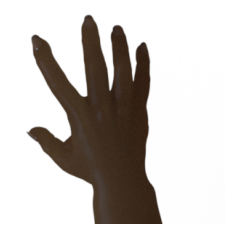

In [ ]:
#podgląd zdjęcia ze zbioru treningowego dla "papier"
#@title Wybierz indeks zdjęcia "papier" ze zbioru treningowego:

#budowa slidera
idx = 456 #@param {type:'slider', min:0, max:840}
names_mapping = dict(enumerate(paper_train_lista))
img_path = os.path.join(paper_train, names_mapping[idx])

#wyświetlenie zdjęcia
img = image.load_img(img_path)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis(False)

(-0.5, 299.5, 299.5, -0.5)

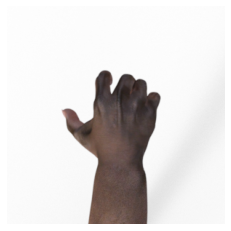

In [ ]:
#podgląd zdjęcia ze zbioru treningowego dla "kamień"
#@title Wybierz indeks zdjęcia "kamień" ze zbioru treningowego:

#budowa slidera
idx = 517 #@param {type:'slider', min:0, max:840}
names_mapping = dict(enumerate(rock_train_lista))
img_path = os.path.join(rock_train, names_mapping[idx])

#wyświetlenie zdjęcia
img = image.load_img(img_path)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis(False)

(-0.5, 299.5, 299.5, -0.5)

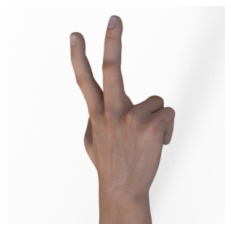

In [ ]:
#podgląd zdjęcia ze zbioru treningowego dla "nożyce"
#@title Wybierz indeks zdjęcia "nożyce" ze zbioru treningowego:

#budowa slidera
idx = 547 #@param {type:'slider', min:0, max:840}
names_mapping = dict(enumerate(scissors_train_lista))
img_path = os.path.join(scissors_train, names_mapping[idx])

#wyświetlenie zdjęcia
img = image.load_img(img_path)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis(False)

####Augumentacja danych - zwiększenie ilości zdjęć

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,      # zakres kąta o który nastąpi obrót
    width_shift_range=0.2,  # przekształcenia obrazu w lewo i w prawo
    height_shift_range=0.2, # przekształcenia obrazu do góry i do dołu
    shear_range=0.2,        # przyciananie
    zoom_range=0.2,         # przybliżanie
    horizontal_flip=True,   # odbicie w poziomie
)

#generator
train_generator = train_datagen.flow_from_directory(directory=train,
                                                   target_size=(300, 300), 
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2520 images belonging to 3 classes.


####Podgląd jak zmieniło się zdjęcie po augumentacji

In [ ]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    nazwy = [os.path.join(directory, nazwy) for nazwy in os.listdir(directory)]
    img_path = nazwy[idx]
    img = image.load_img(img_path, target_size=(300, 300)
    )

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

"Papier"

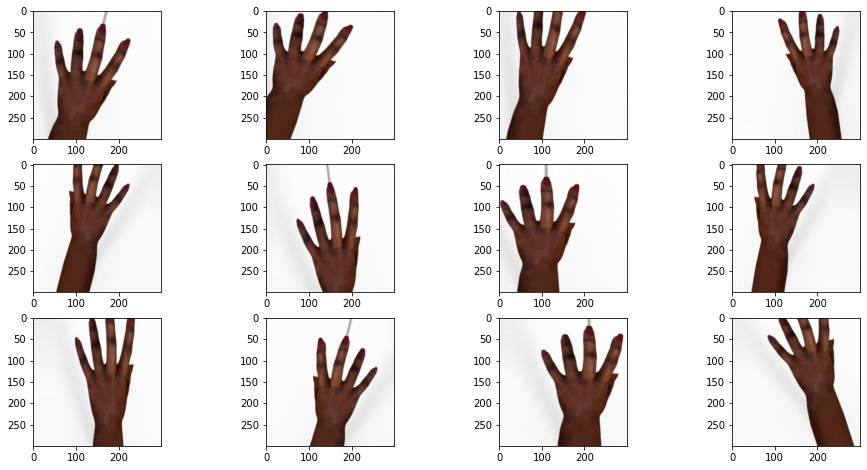

In [ ]:
#@title Wybierz indeks dla zdjęcia ze zbioru treningowego "papier":
idx = 515 #@param {type:'slider', min:0, max:840}            
display_augmented_images(paper_train, idx)

"Kamień"

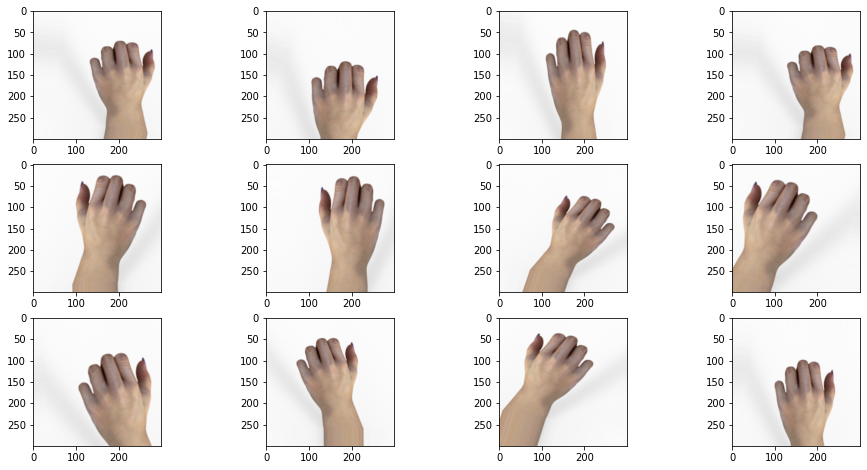

In [ ]:
#@title Wybierz indeks dla zdjęcia ze zbioru treningowego "kamień":
idx = 571 #@param {type:'slider', min:0, max:840}            
display_augmented_images(rock_train, idx)

"Nożyce"

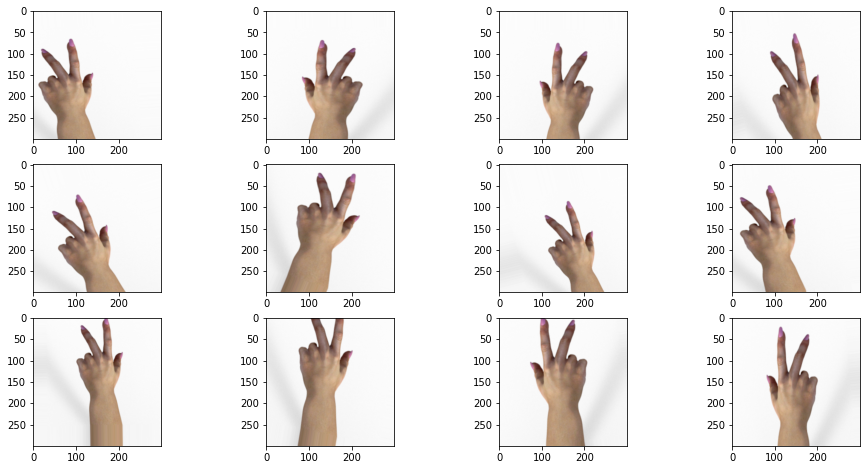

In [ ]:
#@title Wybierz indeks dla zdjęcia ze zbioru treningowego "scissors":
idx = 566 #@param {type:'slider', min:0, max:840}            
display_augmented_images(scissors_train, idx)

###Model

In [ ]:
batch_size = 32

train_size = min(len(paper_train_lista), len(rock_train_lista), len(scissors_train_lista))
steps_per_epoch = train_size // batch_size

In [ ]:
#budowa modelu
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(300,300,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='Adam',
             loss='categorical_crossentropy',  #funkcja straty
             metrics=['accuracy'])

#model.summary()

In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50  
                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
26/26 [==============================] - 20s 759ms/step - loss: 0.4659 - accuracy: 0.8269
Epoch 2/50
26/26 [==============================] - 20s 761ms/step - loss: 0.4341 - accuracy: 0.8546
Epoch 3/50
26/26 [==============================] - 20s 764ms/step - loss: 0.4010 - accuracy: 0.8774
Epoch 4/50
26/26 [==============================] - 20s 771ms/step - loss: 0.3952 - accuracy: 0.8822
Epoch 5/50
26/26 [==============================] - 20s 759ms/step - loss: 0.3569 - accuracy: 0.9038
Epoch 6/50
26/26 [==============================] - 19s 745ms/step - loss: 0.3949 - accuracy: 0.8894
Epoch 7/50
26/26 [==============================] - 19s 745ms/step - loss: 0.4597 - accuracy: 0.8438
Epoch 8/50
26/26 [==============================] - 19s 742ms/step - loss: 0.3551 - accuracy: 0.8858
Epoch 9/50
26/26 [==============================] - 20s 751ms/step - loss: 0.3271 - accuracy: 0.9014
Epoch 10/50
26/26 [==============================] - 19s 746ms/step - loss: 0.2921 - accura

####Wizualizacja dokładności i funkcji straty dla zbioru treningowego i testowego

In [ ]:
#wykresy dla zbioru treningowego
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='Dokładność', mode='markers+lines'))
    fig.update_layout(width=900, height=400, title='Dokładność', xaxis_title='Epoki', yaxis_title='Dokładność', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='Strata', mode='markers+lines', marker_color='rgba(255, 182, 193, .9)'))
    fig.update_layout(width=900, height=400, title='Strata', xaxis_title='Epoki', yaxis_title='Strata', yaxis_type='log')
    fig.show()

plot_hist(history)

Dla zbioru testowego

In [ ]:
test_datagen=ImageDataGenerator()

In [ ]:
#dla zbioru testowego
test_generator = test_datagen.flow_from_directory(directory=test,
                                                   target_size=(300, 300), 
                                                   batch_size=32,
                                                   class_mode='categorical')
history_test = model.fit_generator(generator=test_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=10  
                            )

Found 372 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
26/26 [==============================] - 4s 131ms/step - loss: 0.1821 - accuracy: 0.9516


###Ocena modelu

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(300, 300),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)

y_pred = np.argmax(y_prob, axis=1)

predictions  = pd.DataFrame({'class': y_pred})
predictions

Found 372 images belonging to 3 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



,class
0,0
1,0
2,0
3,0
4,0
...,...
367,0
368,0
369,0
370,0


In [ ]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
y_pred = predictions['class'].values


In [ ]:
#klasy
test_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
classes = list(test_generator.class_indices.keys())
classes

['paper', 'rock', 'scissors']

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[124,   0,   0],
       [124,   0,   0],
       [124,   0,   0]])

In [ ]:
#sprawdzenie metryki f1
print('Wartość metryki F1 wynosi: ',sklearn.metrics.f1_score(y_true,y_pred, average='micro').round(2))

Wartość metryki F1 wynosi:  0.33


###Błędy predykcji

In [ ]:
#budowa Data Frame z wartościami prawdziwymi, przewidzianymi i źle określonymi
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)

errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
paper/testpaper01-00.png,0,0,0
paper/testpaper01-01.png,0,0,0
paper/testpaper01-02.png,0,0,0
paper/testpaper01-03.png,0,0,0
paper/testpaper01-04.png,0,0,0
...,...,...,...
scissors/testscissors04-26.png,2,0,1
scissors/testscissors04-27.png,2,0,1
scissors/testscissors04-28.png,2,0,1
scissors/testscissors04-29.png,2,0,1


In [ ]:
#wyświetlenie niewłaśniwych
errors[errors['is_incorrect'] == 1].index

Index(['rock/testrock01-00.png', 'rock/testrock01-01.png',
       'rock/testrock01-02.png', 'rock/testrock01-03.png',
       'rock/testrock01-04.png', 'rock/testrock01-05.png',
       'rock/testrock01-06.png', 'rock/testrock01-07.png',
       'rock/testrock01-08.png', 'rock/testrock01-09.png',
       ...
       'scissors/testscissors04-21.png', 'scissors/testscissors04-22.png',
       'scissors/testscissors04-23.png', 'scissors/testscissors04-24.png',
       'scissors/testscissors04-25.png', 'scissors/testscissors04-26.png',
       'scissors/testscissors04-27.png', 'scissors/testscissors04-28.png',
       'scissors/testscissors04-29.png', 'scissors/testscissors04-30.png'],
      dtype='object', length=248)

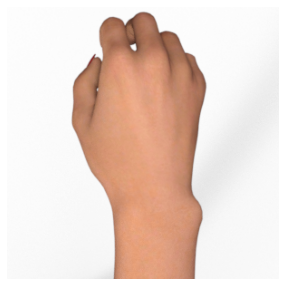

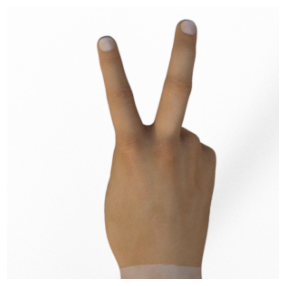

In [ ]:
#wyświetlenie losowej próbki, której model nie rozpoznał
img_path = os.path.join(rock_test, 'testrock01-09.png')
img = image.load_img(img_path)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

img_path = os.path.join(scissors_test, 'testscissors04-26.png')
img = image.load_img(img_path)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

Wnioski:

Na podstawie modelu można zauważyć, że dokładność jest wysoka (na poziomie ponad 90%), z kolei strata jest coraz mniejsza wraz ze wzrostem liczby epok. W zadaniu posługuję się augumentacją danych w celu zwiększenia ilości próbek do modelowania. Wykorzystuję funkcją aktywacji "sigmoid", funkcją kosztu "binary cross_entropy" i optymalizator "adam". Wartość metryki F1 wynosi 0.33.